In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, LeakyReLU, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\meakh\AppData\Roaming\Python\Python37\site-

In [2]:
train_data = ImageDataGenerator(rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)

train_set = train_data.flow_from_directory('./jpg/train', target_size = (64,64), class_mode = 'input')
x=np.concatenate([train_set.next()[0] for i in range(train_set.__len__())])

Found 8189 images belonging to 1 classes.


In [3]:
x.shape

(8189, 64, 64, 3)

In [4]:
disc = Sequential()
disc.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu', input_shape = (64,64,3)))
disc.add(BatchNormalization())    #64*64*64
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.5))
disc.add(BatchNormalization(momentum=0.8))
disc.add(Conv2D(32, (3,3), strides = 2, padding = 'same', activation = 'relu'))
disc.add(BatchNormalization())   #32*32*32   
disc.add(LeakyReLU(alpha = 0.2))

disc.add(Dropout(0.5))
disc.add(Flatten())     #32768
disc.add(Dense(512))
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.3))
disc.add(Dense(256))
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.3))
disc.add(Dense(128))
disc.add(LeakyReLU(alpha = 0.2))
disc.add(Dropout(0.3))
disc.add(Dense(1, activation = 'sigmoid'))

opt = Adam(lr = 0.0002)
disc.compile(optimizer = opt, metrics = ['Accuracy'], loss = 'binary_crossentropy')

disc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        1

In [5]:
n_nodes = 16*16*128
gen = Sequential()
gen.add(Dense(n_nodes, input_shape = (100,)))  
gen.add(LeakyReLU(alpha = 0.3))
gen.add(Reshape((16,16,128)))  #7*7*256
gen.add(Conv2DTranspose(128, (2,2), padding = 'same'))  #16*16*128
gen.add(LeakyReLU(alpha = 0.3))
gen.add(BatchNormalization(momentum=0.8))
gen.add(Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')) #32*32*64
gen.add(LeakyReLU(alpha = 0.3))
gen.add(Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')) #64*64*64
gen.add(LeakyReLU(alpha = 0.3))
gen.add(BatchNormalization(momentum=0.8))

gen.add(Conv2D(3, (2,2), padding = 'same', activation = 'sigmoid')) #64*64*3

opt = Adam(lr = 0.0002)
gen.compile(optimizer = opt, metrics = ['Accuracy'], loss = 'binary_crossentropy')

gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       65664     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)       

In [6]:
model = Sequential()
model.add(gen)
model.add(disc)
opt = Adam(lr = 0.0002)
model.compile(loss = 'binary_crossentropy', optimizer = opt)

In [3]:
from numpy import zeros,ones, expand_dims
from numpy.random import randint, randn

In [4]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, 6552 , n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

def gen_latent_points(dims, n_samples):
    x_input = randn(dims*n_samples)
    x_input = x_input.reshape(n_samples, dims)
    return x_input

def generate_fake_samples(gen, dims, n_samples):
    x_input = gen_latent_points(dims, n_samples)
    X = gen.predict(x_input)
    y = zeros((n_samples,1))
    return X,y

In [5]:
dims = 100

In [13]:
def train(gen, disc, model, dataset, dims, epoch = 10, n_batch = 128):
    bat_per_epo = int(x.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(epoch):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            with tf.device('/gpu:0'):
                d_loss1, d_acc1 = disc.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(gen, dims, half_batch)
            with tf.device('/gpu:0'):
                d_loss2, d_acc2 = disc.train_on_batch(X_fake, y_fake)
            X_gan = gen_latent_points(dims, n_batch)
            y_gan  =ones((n_batch, 1))
            with tf.device('/gpu:0'):
                g_loss = model.train_on_batch(X_gan, y_gan)
            print('>%d, %d, d1=%.10f, acc1=%.10f, d2=%.10f acc2=%.10f gl=%.10f ' % 
                  (i+1, j+1, d_loss1, d_acc1, d_loss2, d_acc2, g_loss,))
        model.save('generator.h5')

In [11]:
train(gen, disc, model, x, dims)

W0923 18:45:10.029984  9932 deprecation.py:323] From C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


>1, 1, d1=1.0219848156, acc1=0.0000000000, d2=5.2962903976 acc2=0.0000000000 gl=0.0131443553 
>1, 2, d1=0.0019474130, acc1=0.2812500000, d2=1.5792073011 acc2=0.0000000000 gl=0.0015037096 
>1, 3, d1=0.0046729753, acc1=0.4062500000, d2=0.0287273675 acc2=0.0000000000 gl=0.0002415400 
>1, 4, d1=0.0020230399, acc1=0.4843750000, d2=0.0017367128 acc2=0.0000000000 gl=0.0000325386 
>1, 5, d1=0.0035169288, acc1=0.5625000000, d2=0.0002790524 acc2=0.0468750000 gl=0.0000297968 
>1, 6, d1=0.0005199204, acc1=0.5937500000, d2=0.0000380495 acc2=0.0625000000 gl=0.0000057253 
>1, 7, d1=0.0022019958, acc1=0.6562500000, d2=0.0008084524 acc2=0.0937500000 gl=0.0000684441 
>1, 8, d1=0.0004423462, acc1=0.5781250000, d2=0.0001627005 acc2=0.3125000000 gl=0.0000011568 
>1, 9, d1=0.0009417760, acc1=0.6406250000, d2=0.0002574876 acc2=0.1718750000 gl=0.0000002142 
>1, 10, d1=0.0000050453, acc1=0.7812500000, d2=0.0004584340 acc2=0.0937500000 gl=0.0000229100 
>1, 11, d1=0.0092646750, acc1=0.7500000000, d2=0.0002637568

>2, 25, d1=0.1894229352, acc1=0.0156250000, d2=1.4975575209 acc2=0.0000000000 gl=3.0181431770 
>2, 26, d1=0.0904048681, acc1=0.0000000000, d2=1.6969549656 acc2=0.0000000000 gl=3.1885826588 
>2, 27, d1=0.1762541234, acc1=0.0000000000, d2=1.3117127419 acc2=0.0000000000 gl=3.0693154335 
>2, 28, d1=0.2646578550, acc1=0.0000000000, d2=1.3030247688 acc2=0.0000000000 gl=2.8856539726 
>2, 29, d1=0.2145805359, acc1=0.0000000000, d2=1.9666914940 acc2=0.0000000000 gl=2.5683343410 
>2, 30, d1=0.1142916307, acc1=0.0000000000, d2=1.2299966812 acc2=0.0000000000 gl=2.8378462791 
>2, 31, d1=0.1867224574, acc1=0.0156250000, d2=1.0278041363 acc2=0.0000000000 gl=2.9425082207 
>2, 32, d1=0.4342446327, acc1=0.0000000000, d2=1.3573663235 acc2=0.0000000000 gl=2.8700444698 
>2, 33, d1=0.3188118041, acc1=0.0000000000, d2=1.3086448908 acc2=0.0000000000 gl=2.5703349113 
>2, 34, d1=0.3435782194, acc1=0.0000000000, d2=1.5247986317 acc2=0.0000000000 gl=2.1875922680 
>2, 35, d1=0.2561830580, acc1=0.0312500000, d2=1.2

>3, 49, d1=0.1077402160, acc1=0.0000000000, d2=0.7960379720 acc2=0.0000000000 gl=2.4128513336 
>3, 50, d1=0.1692747325, acc1=0.0000000000, d2=0.8943164349 acc2=0.0000000000 gl=2.1924827099 
>3, 51, d1=0.2065861672, acc1=0.0000000000, d2=1.1141760349 acc2=0.0000000000 gl=1.8064901829 
>3, 52, d1=0.1126213297, acc1=0.0000000000, d2=1.1461338997 acc2=0.0000000000 gl=1.9489184618 
>3, 53, d1=0.2073994875, acc1=0.0000000000, d2=1.0391132832 acc2=0.0000000000 gl=1.9429001808 
>3, 54, d1=0.1370342523, acc1=0.0000000000, d2=1.0170118809 acc2=0.0000000000 gl=1.9328415394 
>3, 55, d1=0.2103105783, acc1=0.0156250000, d2=1.3252899647 acc2=0.0000000000 gl=1.9255467653 
>3, 56, d1=0.1166648120, acc1=0.0000000000, d2=1.1126995087 acc2=0.0000000000 gl=2.1631603241 
>3, 57, d1=0.1043567657, acc1=0.0000000000, d2=0.7020264864 acc2=0.0000000000 gl=2.6281843185 
>3, 58, d1=0.3186667860, acc1=0.0000000000, d2=0.9186663628 acc2=0.0000000000 gl=1.9644776583 
>3, 59, d1=0.2536259294, acc1=0.0156250000, d2=0.8

>5, 10, d1=0.0547881015, acc1=0.0156250000, d2=0.7012630701 acc2=0.0000000000 gl=1.9720072746 
>5, 11, d1=0.0512095615, acc1=0.0468750000, d2=0.7731516361 acc2=0.0000000000 gl=1.9965323210 
>5, 12, d1=0.0542182997, acc1=0.0312500000, d2=0.8964594603 acc2=0.0000000000 gl=1.8644499779 
>5, 13, d1=0.0656841323, acc1=0.0312500000, d2=0.7130303979 acc2=0.0000000000 gl=1.7258684635 
>5, 14, d1=0.1944925040, acc1=0.0156250000, d2=0.8519024253 acc2=0.0000000000 gl=1.8621313572 
>5, 15, d1=0.2081281096, acc1=0.0156250000, d2=0.7883080244 acc2=0.0000000000 gl=1.8227870464 
>5, 16, d1=0.0337246396, acc1=0.0312500000, d2=0.6635237932 acc2=0.0000000000 gl=1.9416949749 
>5, 17, d1=0.0298671927, acc1=0.0468750000, d2=0.8308952451 acc2=0.0000000000 gl=1.8270289898 
>5, 18, d1=0.0162669141, acc1=0.0156250000, d2=0.9056347609 acc2=0.0000000000 gl=2.0107662678 
>5, 19, d1=0.0827447474, acc1=0.0156250000, d2=0.7097575665 acc2=0.0000000000 gl=2.1834020615 
>5, 20, d1=0.0622338653, acc1=0.0312500000, d2=0.5

>6, 34, d1=0.0212571416, acc1=0.0625000000, d2=0.7442647219 acc2=0.0000000000 gl=1.8353002071 
>6, 35, d1=0.0305566844, acc1=0.0937500000, d2=0.5706509352 acc2=0.0000000000 gl=1.6139030457 
>6, 36, d1=0.0171236377, acc1=0.0937500000, d2=0.6366686821 acc2=0.0000000000 gl=1.5817914009 
>6, 37, d1=0.1268745065, acc1=0.0312500000, d2=0.4860573113 acc2=0.0000000000 gl=1.8173201084 
>6, 38, d1=0.0388971418, acc1=0.1093750000, d2=0.4280694127 acc2=0.0000000000 gl=1.5754963160 
>6, 39, d1=0.0213461779, acc1=0.0781250000, d2=0.8441250324 acc2=0.0000000000 gl=1.6011321545 
>6, 40, d1=0.0145188486, acc1=0.1406250000, d2=0.7280609608 acc2=0.0000000000 gl=1.5241681337 
>6, 41, d1=0.0754515380, acc1=0.1562500000, d2=0.6993910074 acc2=0.0000000000 gl=1.6921985149 
>6, 42, d1=0.0531379059, acc1=0.0312500000, d2=0.5643944740 acc2=0.0000000000 gl=1.6812496185 
>6, 43, d1=0.0407134406, acc1=0.0625000000, d2=0.5519430637 acc2=0.0000000000 gl=1.5877734423 
>6, 44, d1=0.0337315574, acc1=0.2187500000, d2=0.6

>7, 58, d1=0.0235234145, acc1=0.1093750000, d2=0.4654675424 acc2=0.0000000000 gl=1.9635155201 
>7, 59, d1=0.0363391042, acc1=0.1093750000, d2=0.5392161608 acc2=0.0000000000 gl=2.0774850845 
>7, 60, d1=0.0397612192, acc1=0.1250000000, d2=0.5416265726 acc2=0.0000000000 gl=2.0529224873 
>7, 61, d1=0.0182032418, acc1=0.0937500000, d2=0.4879417419 acc2=0.0000000000 gl=2.0800080299 
>7, 62, d1=0.0275536086, acc1=0.0937500000, d2=0.5120798945 acc2=0.0000000000 gl=1.8382203579 
>7, 63, d1=0.0174142979, acc1=0.1093750000, d2=0.7112042904 acc2=0.0000000000 gl=1.9260635376 
>8, 1, d1=0.0473609045, acc1=0.0312500000, d2=0.5583318472 acc2=0.0000000000 gl=1.9053055048 
>8, 2, d1=0.1256926358, acc1=0.0468750000, d2=0.5580160618 acc2=0.0000000000 gl=1.7764316797 
>8, 3, d1=0.0127943596, acc1=0.1093750000, d2=0.5393181443 acc2=0.0000000000 gl=2.0035457611 
>8, 4, d1=0.0165696237, acc1=0.1093750000, d2=0.5746763349 acc2=0.0000000000 gl=1.8904918432 
>8, 5, d1=0.0949203670, acc1=0.0937500000, d2=0.513404

>9, 19, d1=0.1298785508, acc1=0.0625000000, d2=0.5101345181 acc2=0.0000000000 gl=1.6047477722 
>9, 20, d1=0.1245897412, acc1=0.0781250000, d2=0.6549957395 acc2=0.0000000000 gl=1.6747446060 
>9, 21, d1=0.0403786339, acc1=0.0625000000, d2=0.8634527922 acc2=0.0000000000 gl=1.5851106644 
>9, 22, d1=0.0376495905, acc1=0.1093750000, d2=0.7903395295 acc2=0.0000000000 gl=1.7950613499 
>9, 23, d1=0.0224020835, acc1=0.1250000000, d2=0.7438829541 acc2=0.0000000000 gl=2.0182833672 
>9, 24, d1=0.0885120258, acc1=0.0937500000, d2=0.3753442764 acc2=0.0000000000 gl=1.7521201372 
>9, 25, d1=0.1146881133, acc1=0.0468750000, d2=0.4640347362 acc2=0.0000000000 gl=1.8731915951 
>9, 26, d1=0.1048789918, acc1=0.0468750000, d2=0.4915835559 acc2=0.0000000000 gl=1.9210249186 
>9, 27, d1=0.2096609473, acc1=0.0625000000, d2=0.4809672236 acc2=0.0000000000 gl=1.7605881691 
>9, 28, d1=0.0625730455, acc1=0.0625000000, d2=0.4893863201 acc2=0.0000000000 gl=1.5113356113 
>9, 29, d1=0.0626164302, acc1=0.0781250000, d2=0.6

>10, 42, d1=0.1180671677, acc1=0.0625000000, d2=0.6466286778 acc2=0.0000000000 gl=1.3230934143 
>10, 43, d1=0.0518945865, acc1=0.0937500000, d2=0.5106959343 acc2=0.0000000000 gl=1.5720604658 
>10, 44, d1=0.1413340867, acc1=0.0468750000, d2=0.4971492887 acc2=0.0000000000 gl=1.5823302269 
>10, 45, d1=0.0772286654, acc1=0.0625000000, d2=0.6542515159 acc2=0.0000000000 gl=1.6077159643 
>10, 46, d1=0.0576014668, acc1=0.0781250000, d2=0.5621190071 acc2=0.0000000000 gl=1.5448335409 
>10, 47, d1=0.0526274666, acc1=0.0468750000, d2=0.4773862362 acc2=0.0000000000 gl=1.6466530561 
>10, 48, d1=0.0385397300, acc1=0.1250000000, d2=0.4971347153 acc2=0.0000000000 gl=1.6479856968 
>10, 49, d1=0.0837072954, acc1=0.0781250000, d2=0.6001927257 acc2=0.0000000000 gl=1.8128638268 
>10, 50, d1=0.0217392519, acc1=0.1250000000, d2=0.6102937460 acc2=0.0000000000 gl=1.9068470001 
>10, 51, d1=0.0546507463, acc1=0.0468750000, d2=0.6382212043 acc2=0.0000000000 gl=1.7727670670 
>10, 52, d1=0.0436010212, acc1=0.0781250

>12, 2, d1=0.0546405949, acc1=0.0312500000, d2=0.5873732567 acc2=0.0000000000 gl=1.7287619114 
>12, 3, d1=0.0763228983, acc1=0.0312500000, d2=0.5656401515 acc2=0.0000000000 gl=1.4723033905 
>12, 4, d1=0.0671488196, acc1=0.0625000000, d2=0.5009254217 acc2=0.0000000000 gl=1.6993001699 
>12, 5, d1=0.0752087086, acc1=0.0625000000, d2=0.6036452055 acc2=0.0000000000 gl=1.5483889580 
>12, 6, d1=0.0415307358, acc1=0.0000000000, d2=0.6156518459 acc2=0.0000000000 gl=1.3971748352 
>12, 7, d1=0.0438678712, acc1=0.1250000000, d2=0.8998250961 acc2=0.0000000000 gl=1.7139911652 
>12, 8, d1=0.1505594105, acc1=0.0312500000, d2=0.5153198242 acc2=0.0000000000 gl=1.8034598827 
>12, 9, d1=0.1031133831, acc1=0.0625000000, d2=0.4895816147 acc2=0.0000000000 gl=1.6750490665 
>12, 10, d1=0.0718365088, acc1=0.0625000000, d2=0.5687956810 acc2=0.0000000000 gl=1.7583831549 
>12, 11, d1=0.1091558784, acc1=0.0625000000, d2=0.5407646298 acc2=0.0000000000 gl=1.7930978537 
>12, 12, d1=0.1162027419, acc1=0.0468750000, d2=

>13, 25, d1=0.0531813800, acc1=0.0625000000, d2=0.7244508266 acc2=0.0000000000 gl=1.4307420254 
>13, 26, d1=0.0778444409, acc1=0.0468750000, d2=0.4346915781 acc2=0.0000000000 gl=1.3659689426 
>13, 27, d1=0.0805236399, acc1=0.0625000000, d2=0.5979330540 acc2=0.0000000000 gl=1.3052445650 
>13, 28, d1=0.0527844653, acc1=0.0625000000, d2=0.6254165173 acc2=0.0000000000 gl=1.4393088818 
>13, 29, d1=0.0574969612, acc1=0.0312500000, d2=0.5715582967 acc2=0.0000000000 gl=1.4573650360 
>13, 30, d1=0.0299680829, acc1=0.0625000000, d2=0.7355473042 acc2=0.0000000000 gl=1.3879277706 
>13, 31, d1=0.1011671349, acc1=0.0781250000, d2=0.5788501501 acc2=0.0000000000 gl=1.5377566814 
>13, 32, d1=0.0852166414, acc1=0.0625000000, d2=0.6984136105 acc2=0.0000000000 gl=1.6156961918 
>13, 33, d1=0.1219223738, acc1=0.1718750000, d2=0.4888545871 acc2=0.0000000000 gl=1.7861182690 
>13, 34, d1=0.0903713256, acc1=0.1093750000, d2=0.3513121903 acc2=0.0000000000 gl=1.6285156012 
>13, 35, d1=0.0458653644, acc1=0.0468750

>14, 48, d1=0.1419786066, acc1=0.0468750000, d2=0.3940181136 acc2=0.0000000000 gl=1.5739841461 
>14, 49, d1=0.1139037460, acc1=0.0937500000, d2=0.5875298977 acc2=0.0000000000 gl=1.4755312204 
>14, 50, d1=0.1423084736, acc1=0.0937500000, d2=0.6378231049 acc2=0.0000000000 gl=1.4798474312 
>14, 51, d1=0.1612788588, acc1=0.0937500000, d2=0.6909973621 acc2=0.0000000000 gl=1.2537962198 
>14, 52, d1=0.0854424164, acc1=0.0468750000, d2=0.7405354381 acc2=0.0000000000 gl=1.3919270039 
>14, 53, d1=0.0969810933, acc1=0.0625000000, d2=0.7225709558 acc2=0.0000000000 gl=1.3914155960 
>14, 54, d1=0.1270983815, acc1=0.1093750000, d2=0.7468901873 acc2=0.0000000000 gl=1.4882698059 
>14, 55, d1=0.1313113868, acc1=0.0625000000, d2=0.6577761173 acc2=0.0000000000 gl=1.4683983326 
>14, 56, d1=0.0739434585, acc1=0.0937500000, d2=0.6002643704 acc2=0.0000000000 gl=1.7605583668 
>14, 57, d1=0.1488894224, acc1=0.0625000000, d2=0.5518793464 acc2=0.0000000000 gl=1.5650334358 
>14, 58, d1=0.1130582392, acc1=0.1718750

>16, 8, d1=0.0976703316, acc1=0.0781250000, d2=0.6495532990 acc2=0.0000000000 gl=1.5700063705 
>16, 9, d1=0.1154538468, acc1=0.0625000000, d2=1.2505298853 acc2=0.0000000000 gl=1.5949077606 
>16, 10, d1=0.0626350120, acc1=0.0781250000, d2=0.8002367616 acc2=0.0000000000 gl=1.5143873692 
>16, 11, d1=0.1038801223, acc1=0.0781250000, d2=0.7133710384 acc2=0.0000000000 gl=1.6912071705 
>16, 12, d1=0.2631036043, acc1=0.0156250000, d2=0.5412275791 acc2=0.0000000000 gl=1.5409190655 
>16, 13, d1=0.0858371854, acc1=0.0312500000, d2=0.5399451852 acc2=0.0000000000 gl=1.5434210300 
>16, 14, d1=0.2108779252, acc1=0.0468750000, d2=0.6671897173 acc2=0.0000000000 gl=1.3679072857 
>16, 15, d1=0.2191307247, acc1=0.0000000000, d2=0.6967296600 acc2=0.0000000000 gl=1.2219858170 
>16, 16, d1=0.1806288958, acc1=0.0312500000, d2=0.8623448610 acc2=0.0000000000 gl=1.2778202295 
>16, 17, d1=0.1001048684, acc1=0.0468750000, d2=0.9203118086 acc2=0.0000000000 gl=1.2130131721 
>16, 18, d1=0.0573671460, acc1=0.078125000

>17, 31, d1=0.3029536009, acc1=0.0781250000, d2=0.5747705698 acc2=0.0000000000 gl=1.6246608496 
>17, 32, d1=0.1380399764, acc1=0.0312500000, d2=0.6039201617 acc2=0.0000000000 gl=1.4542598724 
>17, 33, d1=0.1505433768, acc1=0.1250000000, d2=0.8940776587 acc2=0.0000000000 gl=1.4102580547 
>17, 34, d1=0.1176740825, acc1=0.1875000000, d2=0.6049477458 acc2=0.0000000000 gl=1.5164853334 
>17, 35, d1=0.0861539915, acc1=0.1250000000, d2=0.6533234119 acc2=0.0000000000 gl=1.3577623367 
>17, 36, d1=0.0819146261, acc1=0.0937500000, d2=0.6754192114 acc2=0.0000000000 gl=1.5222799778 
>17, 37, d1=0.0403614491, acc1=0.1562500000, d2=0.7199670076 acc2=0.0000000000 gl=1.5449125767 
>17, 38, d1=0.0917548984, acc1=0.1093750000, d2=0.8477755189 acc2=0.0000000000 gl=1.5692169666 
>17, 39, d1=0.2908833623, acc1=0.0937500000, d2=0.8234851360 acc2=0.0000000000 gl=1.6674201488 
>17, 40, d1=0.2562102675, acc1=0.0000000000, d2=0.6592525244 acc2=0.0000000000 gl=1.6116971970 
>17, 41, d1=0.2529699802, acc1=0.0312500

>18, 54, d1=0.1291632056, acc1=0.0625000000, d2=0.8932907581 acc2=0.0000000000 gl=1.3349945545 
>18, 55, d1=0.1166075021, acc1=0.0468750000, d2=1.0526721478 acc2=0.0000000000 gl=1.3915128708 
>18, 56, d1=0.0948101208, acc1=0.0468750000, d2=1.3409557343 acc2=0.0000000000 gl=1.4993705750 
>18, 57, d1=0.1466037929, acc1=0.0000000000, d2=0.5776254535 acc2=0.0000000000 gl=1.8187066317 
>18, 58, d1=0.2332825363, acc1=0.0468750000, d2=0.7183418870 acc2=0.0000000000 gl=1.7423496246 
>18, 59, d1=0.3184596300, acc1=0.0000000000, d2=0.5590953231 acc2=0.0000000000 gl=1.5876741409 
>18, 60, d1=0.3800423145, acc1=0.0312500000, d2=0.6099363565 acc2=0.0000000000 gl=1.5968427658 
>18, 61, d1=0.2018438280, acc1=0.0312500000, d2=0.6929812431 acc2=0.0000000000 gl=1.3462978601 
>18, 62, d1=0.1442084908, acc1=0.0468750000, d2=1.0942964554 acc2=0.0000000000 gl=1.3771486282 
>18, 63, d1=0.1256399304, acc1=0.0625000000, d2=0.9228658676 acc2=0.0000000000 gl=1.2776055336 
>19, 1, d1=0.1531755179, acc1=0.09375000

>20, 14, d1=0.2004671991, acc1=0.0156250000, d2=0.8627979159 acc2=0.0000000000 gl=1.5302511454 
>20, 15, d1=0.2348999977, acc1=0.0156250000, d2=0.9565390944 acc2=0.0000000000 gl=1.3659074306 
>20, 16, d1=0.1005282849, acc1=0.0156250000, d2=0.8028366566 acc2=0.0000000000 gl=1.4451525211 
>20, 17, d1=0.3934179544, acc1=0.0468750000, d2=0.6764537096 acc2=0.0000000000 gl=1.3740670681 
>20, 18, d1=0.2469371855, acc1=0.0312500000, d2=0.6225484610 acc2=0.0000000000 gl=1.4339530468 
>20, 19, d1=0.1399139762, acc1=0.0468750000, d2=0.7355737090 acc2=0.0000000000 gl=1.4331011772 
>20, 20, d1=0.2417033613, acc1=0.0468750000, d2=0.9244827032 acc2=0.0000000000 gl=1.2784180641 
>20, 21, d1=0.3316466212, acc1=0.0625000000, d2=0.8947529793 acc2=0.0000000000 gl=1.2767299414 
>20, 22, d1=0.2493680269, acc1=0.0781250000, d2=1.1810276508 acc2=0.0000000000 gl=1.1087663174 
>20, 23, d1=0.1559531540, acc1=0.0312500000, d2=1.1219164133 acc2=0.0000000000 gl=1.3417282104 
>20, 24, d1=0.2585046589, acc1=0.0312500

>21, 37, d1=0.3032253087, acc1=0.0000000000, d2=0.7863577008 acc2=0.0000000000 gl=1.0412971973 
>21, 38, d1=0.2905675173, acc1=0.0312500000, d2=0.9062104225 acc2=0.0000000000 gl=1.2690629959 
>21, 39, d1=0.3338136077, acc1=0.0000000000, d2=0.9800350666 acc2=0.0000000000 gl=1.1232854128 
>21, 40, d1=0.3980722427, acc1=0.0000000000, d2=1.3764419556 acc2=0.0000000000 gl=1.1411681175 
>21, 41, d1=0.1999768615, acc1=0.0156250000, d2=1.2432049513 acc2=0.0000000000 gl=1.1141086817 
>21, 42, d1=0.2582342923, acc1=0.0000000000, d2=1.1023963690 acc2=0.0000000000 gl=1.2302844524 
>21, 43, d1=0.2211243808, acc1=0.0156250000, d2=1.1426742077 acc2=0.0000000000 gl=1.2507467270 
>21, 44, d1=0.1115837097, acc1=0.0000000000, d2=0.9707123041 acc2=0.0000000000 gl=1.2303376198 
>21, 45, d1=0.1853357553, acc1=0.0000000000, d2=0.8984509110 acc2=0.0000000000 gl=1.2131564617 
>21, 46, d1=0.2941654027, acc1=0.0312500000, d2=0.7563067675 acc2=0.0000000000 gl=1.3423072100 
>21, 47, d1=0.1763762534, acc1=0.0156250

>22, 60, d1=0.3491225839, acc1=0.0000000000, d2=1.2451806068 acc2=0.0000000000 gl=1.4317666292 
>22, 61, d1=0.3294430375, acc1=0.0156250000, d2=1.0903455019 acc2=0.0000000000 gl=1.3857671022 
>22, 62, d1=0.4448019564, acc1=0.0000000000, d2=1.2039434910 acc2=0.0000000000 gl=1.3449923992 
>22, 63, d1=0.3594729304, acc1=0.0156250000, d2=1.0247850418 acc2=0.0000000000 gl=1.1263749599 
>23, 1, d1=0.3223842382, acc1=0.0156250000, d2=1.0327777863 acc2=0.0000000000 gl=1.1806950569 
>23, 2, d1=0.2918339968, acc1=0.0156250000, d2=1.4898231030 acc2=0.0000000000 gl=1.0128376484 
>23, 3, d1=0.2697493136, acc1=0.0156250000, d2=1.1202861071 acc2=0.0000000000 gl=1.0718735456 
>23, 4, d1=0.3677162528, acc1=0.0000000000, d2=1.0381462574 acc2=0.0000000000 gl=1.2748159170 
>23, 5, d1=0.2203273475, acc1=0.0000000000, d2=1.2295525074 acc2=0.0000000000 gl=1.1728544235 
>23, 6, d1=0.4075953364, acc1=0.0000000000, d2=1.0091204643 acc2=0.0000000000 gl=1.0723145008 
>23, 7, d1=0.2911723554, acc1=0.0000000000, d2

>24, 20, d1=0.4736349881, acc1=0.0000000000, d2=1.0456573963 acc2=0.0000000000 gl=1.3137743473 
>24, 21, d1=0.4826928973, acc1=0.0000000000, d2=1.1128206253 acc2=0.0000000000 gl=1.2862173319 
>24, 22, d1=0.3534050882, acc1=0.0156250000, d2=1.0292582512 acc2=0.0000000000 gl=1.1718002558 
>24, 23, d1=0.4677368402, acc1=0.0312500000, d2=0.9625296593 acc2=0.0000000000 gl=1.0956346989 
>24, 24, d1=0.4793535471, acc1=0.0000000000, d2=1.0435416698 acc2=0.0000000000 gl=0.9026817083 
>24, 25, d1=0.3246198893, acc1=0.0312500000, d2=1.6922411919 acc2=0.0000000000 gl=1.0116627216 
>24, 26, d1=0.2927314341, acc1=0.0156250000, d2=1.2946631908 acc2=0.0000000000 gl=0.9569618106 
>24, 27, d1=0.2812122703, acc1=0.0000000000, d2=1.2328712940 acc2=0.0000000000 gl=1.0456324816 
>24, 28, d1=0.3952438533, acc1=0.0000000000, d2=1.0604455471 acc2=0.0000000000 gl=1.1770399809 
>24, 29, d1=0.3125560582, acc1=0.0000000000, d2=1.0037745237 acc2=0.0000000000 gl=1.1431436539 
>24, 30, d1=0.3072993159, acc1=0.0156250

>25, 43, d1=0.1938147247, acc1=0.0000000000, d2=1.3237476349 acc2=0.0000000000 gl=0.9318670034 
>25, 44, d1=0.2658570707, acc1=0.0000000000, d2=1.5271047354 acc2=0.0000000000 gl=1.0500593185 
>25, 45, d1=0.3170903623, acc1=0.0468750000, d2=1.1944420338 acc2=0.0000000000 gl=0.9079427123 
>25, 46, d1=0.4157271683, acc1=0.0156250000, d2=1.3065115213 acc2=0.0000000000 gl=1.1096429825 
>25, 47, d1=0.4358344674, acc1=0.0000000000, d2=1.0750966072 acc2=0.0000000000 gl=1.2053778172 
>25, 48, d1=0.2022304833, acc1=0.0312500000, d2=0.9419611692 acc2=0.0000000000 gl=1.2099794149 
>25, 49, d1=0.2943861485, acc1=0.0156250000, d2=1.0153489113 acc2=0.0000000000 gl=1.0859643221 
>25, 50, d1=0.4594531953, acc1=0.0312500000, d2=1.2522695065 acc2=0.0000000000 gl=1.1093876362 
>25, 51, d1=0.2852896154, acc1=0.0156250000, d2=1.2417695522 acc2=0.0000000000 gl=1.0517650843 
>25, 52, d1=0.3133484721, acc1=0.0156250000, d2=1.1594599485 acc2=0.0000000000 gl=1.0814456940 
>25, 53, d1=0.2324143350, acc1=0.0156250

>27, 3, d1=0.1715608686, acc1=0.0312500000, d2=1.3367542028 acc2=0.0000000000 gl=0.8983211517 
>27, 4, d1=0.3295371830, acc1=0.0156250000, d2=1.1716083288 acc2=0.0000000000 gl=1.1065943241 
>27, 5, d1=0.3412916362, acc1=0.0000000000, d2=1.3546293974 acc2=0.0000000000 gl=0.8939645290 
>27, 6, d1=0.3234687150, acc1=0.0156250000, d2=1.0933055878 acc2=0.0000000000 gl=0.8603550792 
>27, 7, d1=0.3296803236, acc1=0.0000000000, d2=1.3035144806 acc2=0.0000000000 gl=1.0488706827 
>27, 8, d1=0.3532153964, acc1=0.0000000000, d2=1.1828396320 acc2=0.0000000000 gl=0.9413332939 
>27, 9, d1=0.5449426174, acc1=0.0156250000, d2=1.3123378754 acc2=0.0000000000 gl=0.9994483590 
>27, 10, d1=0.2940546870, acc1=0.0156250000, d2=1.1717835665 acc2=0.0000000000 gl=0.8515609503 
>27, 11, d1=0.2366087437, acc1=0.0156250000, d2=1.3600103855 acc2=0.0000000000 gl=0.9812573195 
>27, 12, d1=0.3126232922, acc1=0.0468750000, d2=1.0016195774 acc2=0.0000000000 gl=0.9579977989 
>27, 13, d1=0.2953060567, acc1=0.0156250000, d2

>28, 26, d1=0.2990632057, acc1=0.0156250000, d2=1.5083854198 acc2=0.0000000000 gl=0.8407130241 
>28, 27, d1=0.2390299886, acc1=0.0156250000, d2=1.4431523085 acc2=0.0000000000 gl=0.6809500456 
>28, 28, d1=0.2826839685, acc1=0.0468750000, d2=1.0958515406 acc2=0.0000000000 gl=0.9127501249 
>28, 29, d1=0.1998549253, acc1=0.0000000000, d2=1.1205869913 acc2=0.0000000000 gl=0.8071433902 
>28, 30, d1=0.2453777641, acc1=0.0000000000, d2=1.4565415382 acc2=0.0000000000 gl=0.8667368293 
>28, 31, d1=0.4982168674, acc1=0.0156250000, d2=0.8867443800 acc2=0.0000000000 gl=0.9406707287 
>28, 32, d1=0.4126881659, acc1=0.0156250000, d2=1.1557593346 acc2=0.0000000000 gl=0.9615530968 
>28, 33, d1=0.2570097446, acc1=0.0156250000, d2=1.2983767986 acc2=0.0000000000 gl=0.9691047668 
>28, 34, d1=0.3242773414, acc1=0.0156250000, d2=1.0548684597 acc2=0.0000000000 gl=0.8440161347 
>28, 35, d1=0.2367178649, acc1=0.0156250000, d2=1.0684928894 acc2=0.0000000000 gl=0.8791106939 
>28, 36, d1=0.3226705194, acc1=0.0000000

>29, 49, d1=0.3170260191, acc1=0.0000000000, d2=0.9416493177 acc2=0.0000000000 gl=0.8888499737 
>29, 50, d1=0.3501373827, acc1=0.0156250000, d2=0.9486702085 acc2=0.0000000000 gl=0.7975855470 
>29, 51, d1=0.3722029924, acc1=0.0156250000, d2=1.1270939112 acc2=0.0000000000 gl=0.7775261998 
>29, 52, d1=0.3758864999, acc1=0.0000000000, d2=1.2082421780 acc2=0.0000000000 gl=0.7311816216 
>29, 53, d1=0.2660145760, acc1=0.0625000000, d2=1.1396135092 acc2=0.0000000000 gl=0.8488065004 
>29, 54, d1=0.2871596813, acc1=0.0156250000, d2=1.3490843773 acc2=0.0000000000 gl=0.7018019557 
>29, 55, d1=0.2657626569, acc1=0.0156250000, d2=1.1625876427 acc2=0.0000000000 gl=0.7481499314 
>29, 56, d1=0.3889419436, acc1=0.0000000000, d2=1.2735147476 acc2=0.0000000000 gl=0.7041105032 
>29, 57, d1=0.3618039191, acc1=0.0000000000, d2=1.3265042305 acc2=0.0000000000 gl=0.6919494867 
>29, 58, d1=0.2876815200, acc1=0.0000000000, d2=1.0926532745 acc2=0.0000000000 gl=0.7426863313 
>29, 59, d1=0.3200742900, acc1=0.0156250

In [12]:
noise = np.random.normal(0, 1, (5 * 5, 100))
gen_imgs = gen.predict(noise)

In [13]:
import matplotlib.pyplot as plt

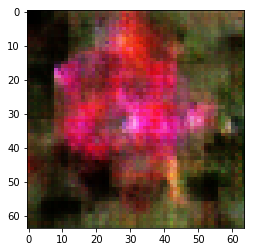

In [14]:
plt.imshow(gen_imgs[0])

In [37]:
def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, './flower_gan/gan.h5')
    discriminator.trainable = True
    save_model(generator, './flower_gan/generator.h5')
    save_model(discriminator, './flower_gan/discriminator.h5')

In [10]:
from tensorflow.keras.models import save_model, load_model

In [38]:
save(model, gen, disc)

In [11]:
def load():
    discriminator = load_model('./flower_gan/discriminator.h5')
    generator = load_model('./flower_gan/generator.h5')
    gan = load_model('./flower_gan/gan.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [12]:
a,b,c = load()

W0924 18:01:34.702545  9016 deprecation.py:323] From C:\Users\meakh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0924 18:01:44.219032  9016 hdf5_format.py:192] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         3426051   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 16962977  
Total params: 20,389,028
Trainable params: 3,425,667
Non-trainable params: 16,963,361
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
______________

In [14]:
train(b, c, a, x, dims)

>1, 1, d1=0.2764802575, acc1=0.0312500000, d2=1.0694386959 acc2=0.0000000000 gl=0.4594839811 
>1, 2, d1=0.5015884638, acc1=0.0000000000, d2=0.9494134784 acc2=0.0000000000 gl=0.5629156232 
>1, 3, d1=0.5264790654, acc1=0.0000000000, d2=0.6268235445 acc2=0.0000000000 gl=0.5366057158 
>1, 4, d1=0.8215988874, acc1=0.0000000000, d2=0.5196435452 acc2=0.0000000000 gl=0.5293591022 
>1, 5, d1=0.8252503872, acc1=0.0000000000, d2=0.3952620029 acc2=0.0000000000 gl=0.4541498721 
>1, 6, d1=0.8712189794, acc1=0.0000000000, d2=0.3682850003 acc2=0.0000000000 gl=0.4172123075 
>1, 7, d1=1.0046930313, acc1=0.0000000000, d2=0.4105656147 acc2=0.0000000000 gl=0.4276821017 
>1, 8, d1=0.9513615966, acc1=0.0000000000, d2=0.3892263174 acc2=0.0000000000 gl=0.4124161899 
>1, 9, d1=1.1390205622, acc1=0.0000000000, d2=0.4077965617 acc2=0.0000000000 gl=0.4237893224 
>1, 10, d1=0.8795164824, acc1=0.0000000000, d2=0.5447785854 acc2=0.0000000000 gl=0.4503461123 
>1, 11, d1=0.8244096041, acc1=0.0000000000, d2=0.4379221201

>2, 25, d1=0.2599207163, acc1=0.1250000000, d2=0.2705004215 acc2=0.0000000000 gl=0.0372106433 
>2, 26, d1=0.2158064246, acc1=0.1250000000, d2=0.1296414435 acc2=0.0000000000 gl=0.0317071415 
>2, 27, d1=0.0434048101, acc1=0.1093750000, d2=0.0443219319 acc2=0.0000000000 gl=0.0143115055 
>2, 28, d1=0.1409676373, acc1=0.1250000000, d2=0.2797689736 acc2=0.0000000000 gl=0.0253604539 
>2, 29, d1=0.1913081855, acc1=0.2343750000, d2=0.2113250494 acc2=0.0000000000 gl=0.0171287879 
>2, 30, d1=0.2330669165, acc1=0.1875000000, d2=0.1399868429 acc2=0.0000000000 gl=0.0277219769 
>2, 31, d1=0.0621669143, acc1=0.2500000000, d2=0.0289911646 acc2=0.0000000000 gl=0.0301851518 
>2, 32, d1=0.0876967832, acc1=0.2968750000, d2=0.1712298095 acc2=0.0000000000 gl=0.0337558351 
>2, 33, d1=0.0440802984, acc1=0.3437500000, d2=0.3520011306 acc2=0.0000000000 gl=0.0166857876 
>2, 34, d1=0.1096774936, acc1=0.1562500000, d2=0.1005346403 acc2=0.0000000000 gl=0.0113456454 
>2, 35, d1=0.0792823434, acc1=0.2343750000, d2=0.0

>3, 49, d1=0.0294919964, acc1=0.4843750000, d2=0.0512026362 acc2=0.0000000000 gl=0.0137232775 
>3, 50, d1=0.0463840105, acc1=0.3906250000, d2=0.0097405808 acc2=0.0000000000 gl=0.0034158588 
>3, 51, d1=0.0474911854, acc1=0.5468750000, d2=0.0199000519 acc2=0.0000000000 gl=0.0025259026 
>3, 52, d1=0.0053950096, acc1=0.5000000000, d2=0.0877881944 acc2=0.0000000000 gl=0.0063405656 
>3, 53, d1=0.0114022382, acc1=0.5156250000, d2=0.0090253167 acc2=0.0156250000 gl=0.0034745480 
>3, 54, d1=0.0333628133, acc1=0.5625000000, d2=0.0114810616 acc2=0.0000000000 gl=0.0006245364 
>3, 55, d1=0.0564147495, acc1=0.3906250000, d2=0.0125397528 acc2=0.0000000000 gl=0.0048439684 
>3, 56, d1=0.0518575571, acc1=0.4375000000, d2=0.0377130546 acc2=0.0000000000 gl=0.0036838218 
>3, 57, d1=0.0043555042, acc1=0.5468750000, d2=0.1404555738 acc2=0.0000000000 gl=0.0094818473 
>3, 58, d1=0.0086823739, acc1=0.4531250000, d2=0.1157068685 acc2=0.0156250000 gl=0.0028676945 
>3, 59, d1=0.0194421336, acc1=0.4375000000, d2=0.0

>5, 10, d1=0.0201944020, acc1=0.6718750000, d2=0.0053747715 acc2=0.0000000000 gl=0.0001535655 
>5, 11, d1=0.0637719408, acc1=0.5937500000, d2=0.0028017324 acc2=0.0156250000 gl=0.0027231425 
>5, 12, d1=0.0014243557, acc1=0.5000000000, d2=0.0086528342 acc2=0.0156250000 gl=0.0019406436 
>5, 13, d1=0.0067628790, acc1=0.5625000000, d2=0.0021257778 acc2=0.0000000000 gl=0.0063265506 
>5, 14, d1=0.0038803136, acc1=0.7812500000, d2=0.0590174012 acc2=0.0156250000 gl=0.0008276107 
>5, 15, d1=0.0049022250, acc1=0.6093750000, d2=0.0026453421 acc2=0.0156250000 gl=0.0021310868 
>5, 16, d1=0.0001801677, acc1=0.7187500000, d2=0.0470679253 acc2=0.0156250000 gl=0.0005564006 
>5, 17, d1=0.0020453944, acc1=0.6875000000, d2=0.0111892354 acc2=0.0156250000 gl=0.0014573567 
>5, 18, d1=0.0043728347, acc1=0.5781250000, d2=0.0061087534 acc2=0.0156250000 gl=0.0004361400 
>5, 19, d1=0.0145445885, acc1=0.4843750000, d2=0.1069060639 acc2=0.0312500000 gl=0.0008491896 
>5, 20, d1=0.0111736599, acc1=0.5312500000, d2=0.0

>6, 34, d1=0.0048304205, acc1=0.7187500000, d2=0.0022773920 acc2=0.0156250000 gl=0.0001011600 
>6, 35, d1=0.0003759292, acc1=0.7968750000, d2=0.0055903941 acc2=0.0000000000 gl=0.0007303501 
>6, 36, d1=0.0578497872, acc1=0.7187500000, d2=0.0023324674 acc2=0.0156250000 gl=0.0005928602 
>6, 37, d1=0.0100164032, acc1=0.7656250000, d2=0.0038804696 acc2=0.0156250000 gl=0.0004442506 
>6, 38, d1=0.0013077863, acc1=0.7968750000, d2=0.0102139469 acc2=0.0156250000 gl=0.0001994005 
>6, 39, d1=0.0000467637, acc1=0.7031250000, d2=0.0046408381 acc2=0.0468750000 gl=0.0008018430 
>6, 40, d1=0.0046489639, acc1=0.6562500000, d2=0.0020346246 acc2=0.0468750000 gl=0.0000386058 
>6, 41, d1=0.0027762880, acc1=0.7968750000, d2=0.0017532560 acc2=0.0000000000 gl=0.0002434668 
>6, 42, d1=0.0000406841, acc1=0.6562500000, d2=0.0021603939 acc2=0.0156250000 gl=0.0005560832 
>6, 43, d1=0.0015518212, acc1=0.6093750000, d2=0.0069670258 acc2=0.0000000000 gl=0.0002119648 
>6, 44, d1=0.0191028137, acc1=0.7656250000, d2=0.0

>7, 58, d1=0.0111905970, acc1=0.6250000000, d2=0.0010371946 acc2=0.0156250000 gl=0.0003367950 
>7, 59, d1=0.0000577912, acc1=0.7812500000, d2=0.0012789849 acc2=0.0312500000 gl=0.0007308271 
>7, 60, d1=0.0039009601, acc1=0.6875000000, d2=0.0011170803 acc2=0.0156250000 gl=0.0000131421 
>7, 61, d1=0.0002159061, acc1=0.8125000000, d2=0.0007564563 acc2=0.0312500000 gl=0.0003564824 
>7, 62, d1=0.0010008592, acc1=0.6875000000, d2=0.0041173529 acc2=0.0000000000 gl=0.0007147864 
>7, 63, d1=0.0000005038, acc1=0.8593750000, d2=0.0017717003 acc2=0.0000000000 gl=0.0001744340 
>8, 1, d1=0.0020667790, acc1=0.7968750000, d2=0.0042431094 acc2=0.0156250000 gl=0.0009344198 
>8, 2, d1=0.0012243504, acc1=0.7812500000, d2=0.0010276898 acc2=0.0625000000 gl=0.0001177513 
>8, 3, d1=0.0015701090, acc1=0.6406250000, d2=0.0009744457 acc2=0.0468750000 gl=0.0014420461 
>8, 4, d1=0.0003096021, acc1=0.7656250000, d2=0.0026459978 acc2=0.0625000000 gl=0.0000302470 
>8, 5, d1=0.0000249989, acc1=0.8437500000, d2=0.004979

>9, 19, d1=0.0001058745, acc1=0.9531250000, d2=0.0015704884 acc2=0.0312500000 gl=0.0000316122 
>9, 20, d1=0.0012221548, acc1=0.8437500000, d2=0.0007240389 acc2=0.0156250000 gl=0.0021873282 
>9, 21, d1=0.0000022772, acc1=0.8906250000, d2=0.0007736609 acc2=0.0468750000 gl=0.0000196902 
>9, 22, d1=0.0013443988, acc1=0.8593750000, d2=0.0327406451 acc2=0.0156250000 gl=0.0000839072 
>9, 23, d1=0.0000710080, acc1=0.7031250000, d2=0.0051353551 acc2=0.0156250000 gl=0.0000169474 
>9, 24, d1=0.0059571215, acc1=0.7656250000, d2=0.0052897646 acc2=0.0781250000 gl=0.0000126212 
>9, 25, d1=0.0456244648, acc1=0.7500000000, d2=0.0009467368 acc2=0.0781250000 gl=0.0007440148 
>9, 26, d1=0.0002047147, acc1=0.8437500000, d2=0.0012666127 acc2=0.0312500000 gl=0.0006894758 
>9, 27, d1=0.0034928576, acc1=0.7343750000, d2=0.0436736755 acc2=0.0312500000 gl=0.0000835430 
>9, 28, d1=0.0000210600, acc1=0.6875000000, d2=0.0078933146 acc2=0.0312500000 gl=0.0000164560 
>9, 29, d1=0.0001696749, acc1=0.8593750000, d2=0.0

>10, 42, d1=0.0000081689, acc1=0.9062500000, d2=0.0009568938 acc2=0.0625000000 gl=0.0002098655 
>10, 43, d1=0.0003842521, acc1=0.7812500000, d2=0.0010546804 acc2=0.0625000000 gl=0.0000357884 
>10, 44, d1=0.0000159536, acc1=0.8125000000, d2=0.0001733591 acc2=0.0781250000 gl=0.0000942716 
>10, 45, d1=0.0000016327, acc1=0.9062500000, d2=0.0003684605 acc2=0.0312500000 gl=0.0005089284 
>10, 46, d1=0.0009257414, acc1=0.9062500000, d2=0.0005461149 acc2=0.0000000000 gl=0.0005588105 
>10, 47, d1=0.0022255301, acc1=0.7968750000, d2=0.0012677485 acc2=0.0312500000 gl=0.0000099050 
>10, 48, d1=0.0000142870, acc1=0.8906250000, d2=0.0003839727 acc2=0.0468750000 gl=0.0000215930 
>10, 49, d1=0.0000001090, acc1=0.9531250000, d2=0.0003566060 acc2=0.0312500000 gl=0.0000967655 
>10, 50, d1=0.0000851479, acc1=0.7500000000, d2=0.0005725332 acc2=0.0937500000 gl=0.0000084166 
>10, 51, d1=0.0000011800, acc1=0.9062500000, d2=0.0096503599 acc2=0.0781250000 gl=0.0000366307 
>10, 52, d1=0.0000023572, acc1=0.8750000

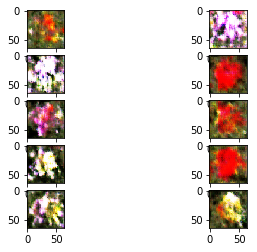

In [22]:
noise = np.random.normal(0, 1, (5 * 5, 100))
gen_imgs = b.predict(noise)

import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(gen_imgs[i])

plt.show()

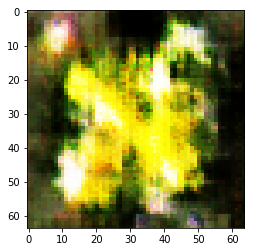

In [26]:
plt.imshow(gen_imgs[16])